TODO:
- Pick a few quality check neighborhoods
- Run optimization with different [learning rate, n_latents, max_iter]

# Train the Linear Latent Variable Model

This is for testing, to try training the model on different neighborhoods defined in notebook 2.

In [1]:
import pathlib
import corner
import astropy.coordinates as coord
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import h5py
from tqdm import tqdm, trange
from sklearn.neighbors import KDTree
from pyia import GaiaData
from scipy.stats import binned_statistic

from jax.config import config
config.update("jax_enable_x64", True)
import jaxopt
import optax

import schlummernd as sch
from schlummernd import ParameterState
from schlummernd.lvm import LinearLVM
from schlummernd.plot import colored_corner

In [2]:
conf = sch.Config.parse_yaml('../config.yml')

## Load APOGEE x Gaia data

see `Assemble-data.ipynb` for more information.

In [3]:
g_all = conf.load_training_data()

In [4]:
hoods = np.load(
    conf.data_path / 'training_neighborhoods.npy', 
    allow_pickle=True
)
len(hoods)

1491

In [568]:
# k = 250 # MSTO
# k = 50 # RC
k = 787
g = g_all[hoods[k]]
# g = g.filter(phot_g_mean_mag=(None, 15.5*u.mag))
g = g.filter(J_ERR=(0, 0.2), AK_WISE=(-0.1, 0.1))  # SFD_EBV=(0, 0.2))
len(g)

132

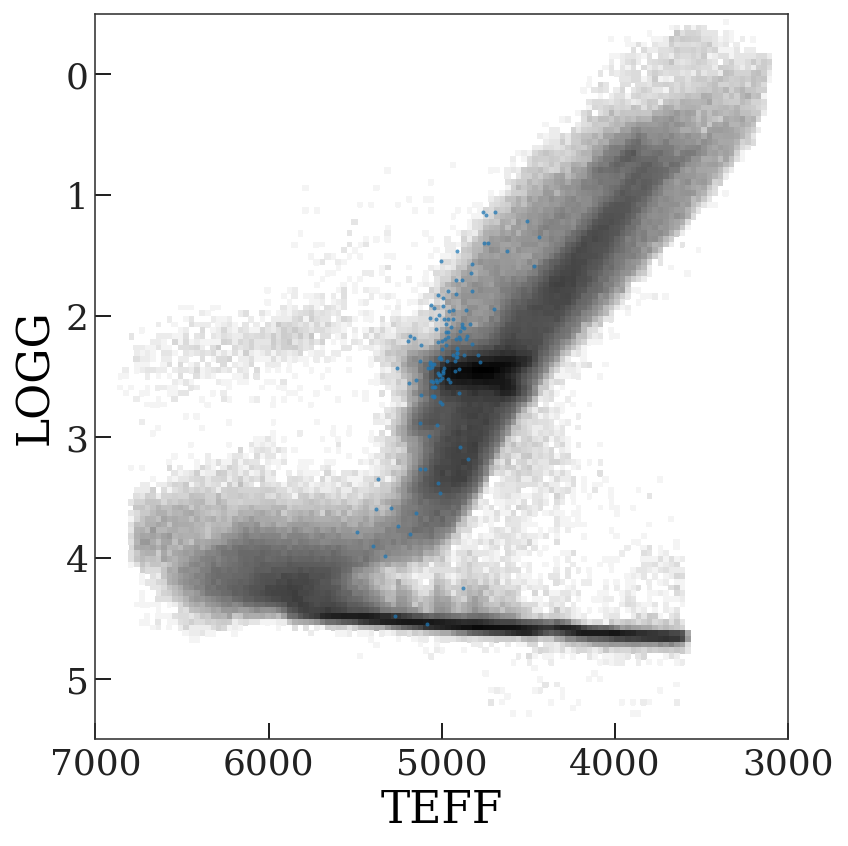

In [570]:
# Spectroscopic HR diagram of the subset stars:
fig, ax = plt.subplots(figsize=(6, 6))

teff_logg_bins = (
    np.linspace(3000, 7000, 128),
    np.linspace(-0.5, 5.5, 128)
)
ax.hist2d(g_all.TEFF,
          g_all.LOGG,
          bins=teff_logg_bins,
          norm=mpl.colors.LogNorm(),
          cmap='Greys')

ax.plot(g.TEFF,
        g.LOGG,
        ls='none', marker='o', mew=0, ms=2.,
        color='tab:blue', alpha=0.75)

ax.set_xlim(teff_logg_bins[0].max(),
            teff_logg_bins[0].min())
ax.set_ylim(teff_logg_bins[1].max(),
            teff_logg_bins[1].min())

ax.set_xlabel('TEFF')
ax.set_ylabel('LOGG')

fig.tight_layout()

In [571]:
bprp = (g.phot_bp_mean_mag - g.phot_rp_mean_mag).value
mg = (g.phot_g_mean_mag - g.get_distance(allow_negative=True).distmod).value

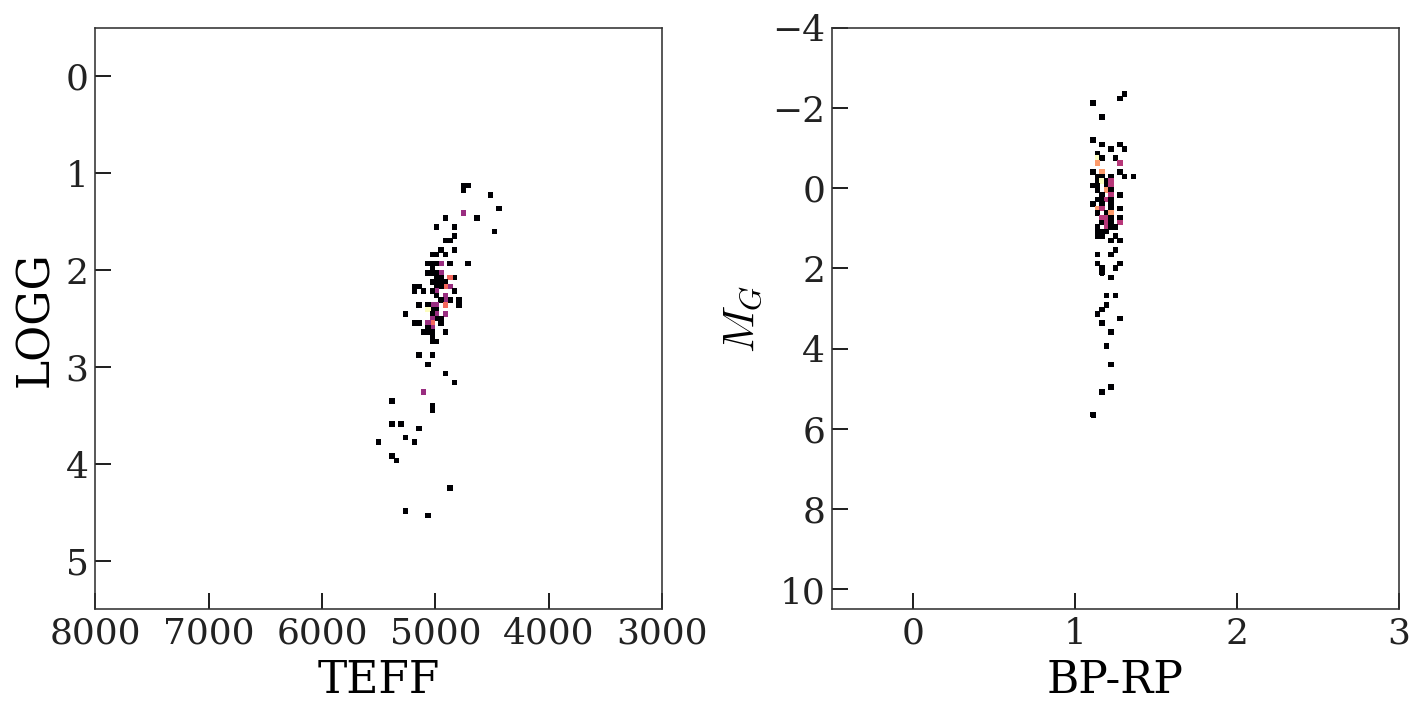

In [572]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
H, xb, yb, _ = ax.hist2d(
    g.TEFF,
    g.LOGG,
    bins=(
        np.linspace(3000, 8000, 128),
        np.linspace(-0.5, 5.5, 128)
    ),
    norm=mpl.colors.LogNorm()
)
ax.set_xlim(xb.max(), xb.min())
ax.set_ylim(yb.max(), yb.min())
ax.set_xlabel('TEFF')
ax.set_ylabel('LOGG')

ax = axes[1]
H, xb, yb, _ = ax.hist2d(
    bprp,
    mg,
    bins=(
        np.linspace(-0.5, 3, 128),
        np.linspace(-4, 10.5, 128)
    ),
    norm=mpl.colors.LogNorm()
)
ax.set_xlim(xb.min(), xb.max())
ax.set_ylim(yb.max(), yb.min())
ax.set_xlabel('BP-RP')
ax.set_ylabel('$M_G$')

fig.tight_layout()

# Construct features and labels

Make list of possible labels (and label weights), aligned with the features.

In [573]:
other_features = {
#     r"$G-G_{\rm RP}$": (
#         0.1 * (g.phot_bp_mean_mag - g.phot_rp_mean_mag).value,
#         0.1 * np.sqrt(1/g.phot_bp_mean_flux_over_error**2 + 1/g.phot_rp_mean_flux_over_error**2)
#     ),
    r"$G-J$": (
        0.5 * (g.phot_g_mean_mag.value - g.J),
        0.5 * np.sqrt(1/g.phot_g_mean_flux_over_error**2 + g.J_ERR**2)
    ),
}
f_all = sch.Features.from_gaiadata(g, n_bp=55, n_rp=55, **other_features)

In [574]:
# schmag_factor = 10 ** (0.2 * g.phot_g_mean_mag.value) / 100.
# pm = np.sqrt(g.pmra.value**2 + g.pmdec.value**2)
# plt.scatter(
#     g.parallax.value * schmag_factor, 
#     pm * schmag_factor,
#     s=2,
#     alpha=0.5
# )
# plt.xlabel('schpar')
# plt.ylabel('schpro')

In [575]:
# schmag_factor = 10 ** (0.2 * g.phot_g_mean_mag.value) / 100.
# # schmag_factor = 10 ** (0.2 * g.H)
# plt.errorbar(
#     g.parallax.value, 
#     (g.parallax.value * schmag_factor),
#     xerr=g.parallax_error.value,
#     yerr=g.parallax_error.value * schmag_factor,
#     ls='none'
# )

In [576]:
lbl = sch.Labels()

# schmag_factor = 10 ** (0.2 * g.phot_g_mean_mag.value) / 100.
# lbl.add_label(
#     'schmag',
#     value=g.parallax.value * schmag_factor,
#     err=g.parallax_error.value * schmag_factor,
#     label='$G$-band schmag [absmgy$^{-1/2}$]'
# )
lbl.add_label(
    'TEFF',
    g.TEFF,
    g.TEFF_ERR,
    label=r"$T_{\rm eff}$ [K]"
)
lbl.add_label(
    'FE_H',
    g.FE_H,
    g.FE_H_ERR,
    label=r"$[{\rm Fe}/{\rm H}]$"
)
lbl.add_label(
    'MG_H',
    g.MG_FE + g.FE_H,
    np.sqrt(g.MG_FE_ERR**2 + g.FE_H_ERR**2),
    label=r"$[{\rm Mg}/{\rm H}]$"
)
# lbl.add_label(
#     'MG_FE',
#     g.MG_FE,
#     g.MG_FE_ERR,
#     label=r"$[{\rm Mg}/{\rm Fe}]$"
# )
lbl.add_label(
    'logg',
    g.LOGG,
    g.LOGG_ERR,
    label=r"$\log g$"
)
# lbl.add_label(
#     'EBV',
#     g.SFD_EBV,
#     np.sqrt(0.01**2 + (0.02 * np.abs(g.SFD_EBV))**2),
#     label=r"E$(B-V)$"
# )
lbl.add_label(
    'AK_TARG',
    g.AK_WISE,
    np.full_like(g.AK_WISE, 0.04),
    label=r"$A_K$"
)

assert np.all(lbl.y_err > 0)

lbl.y.shape

(132, 5)

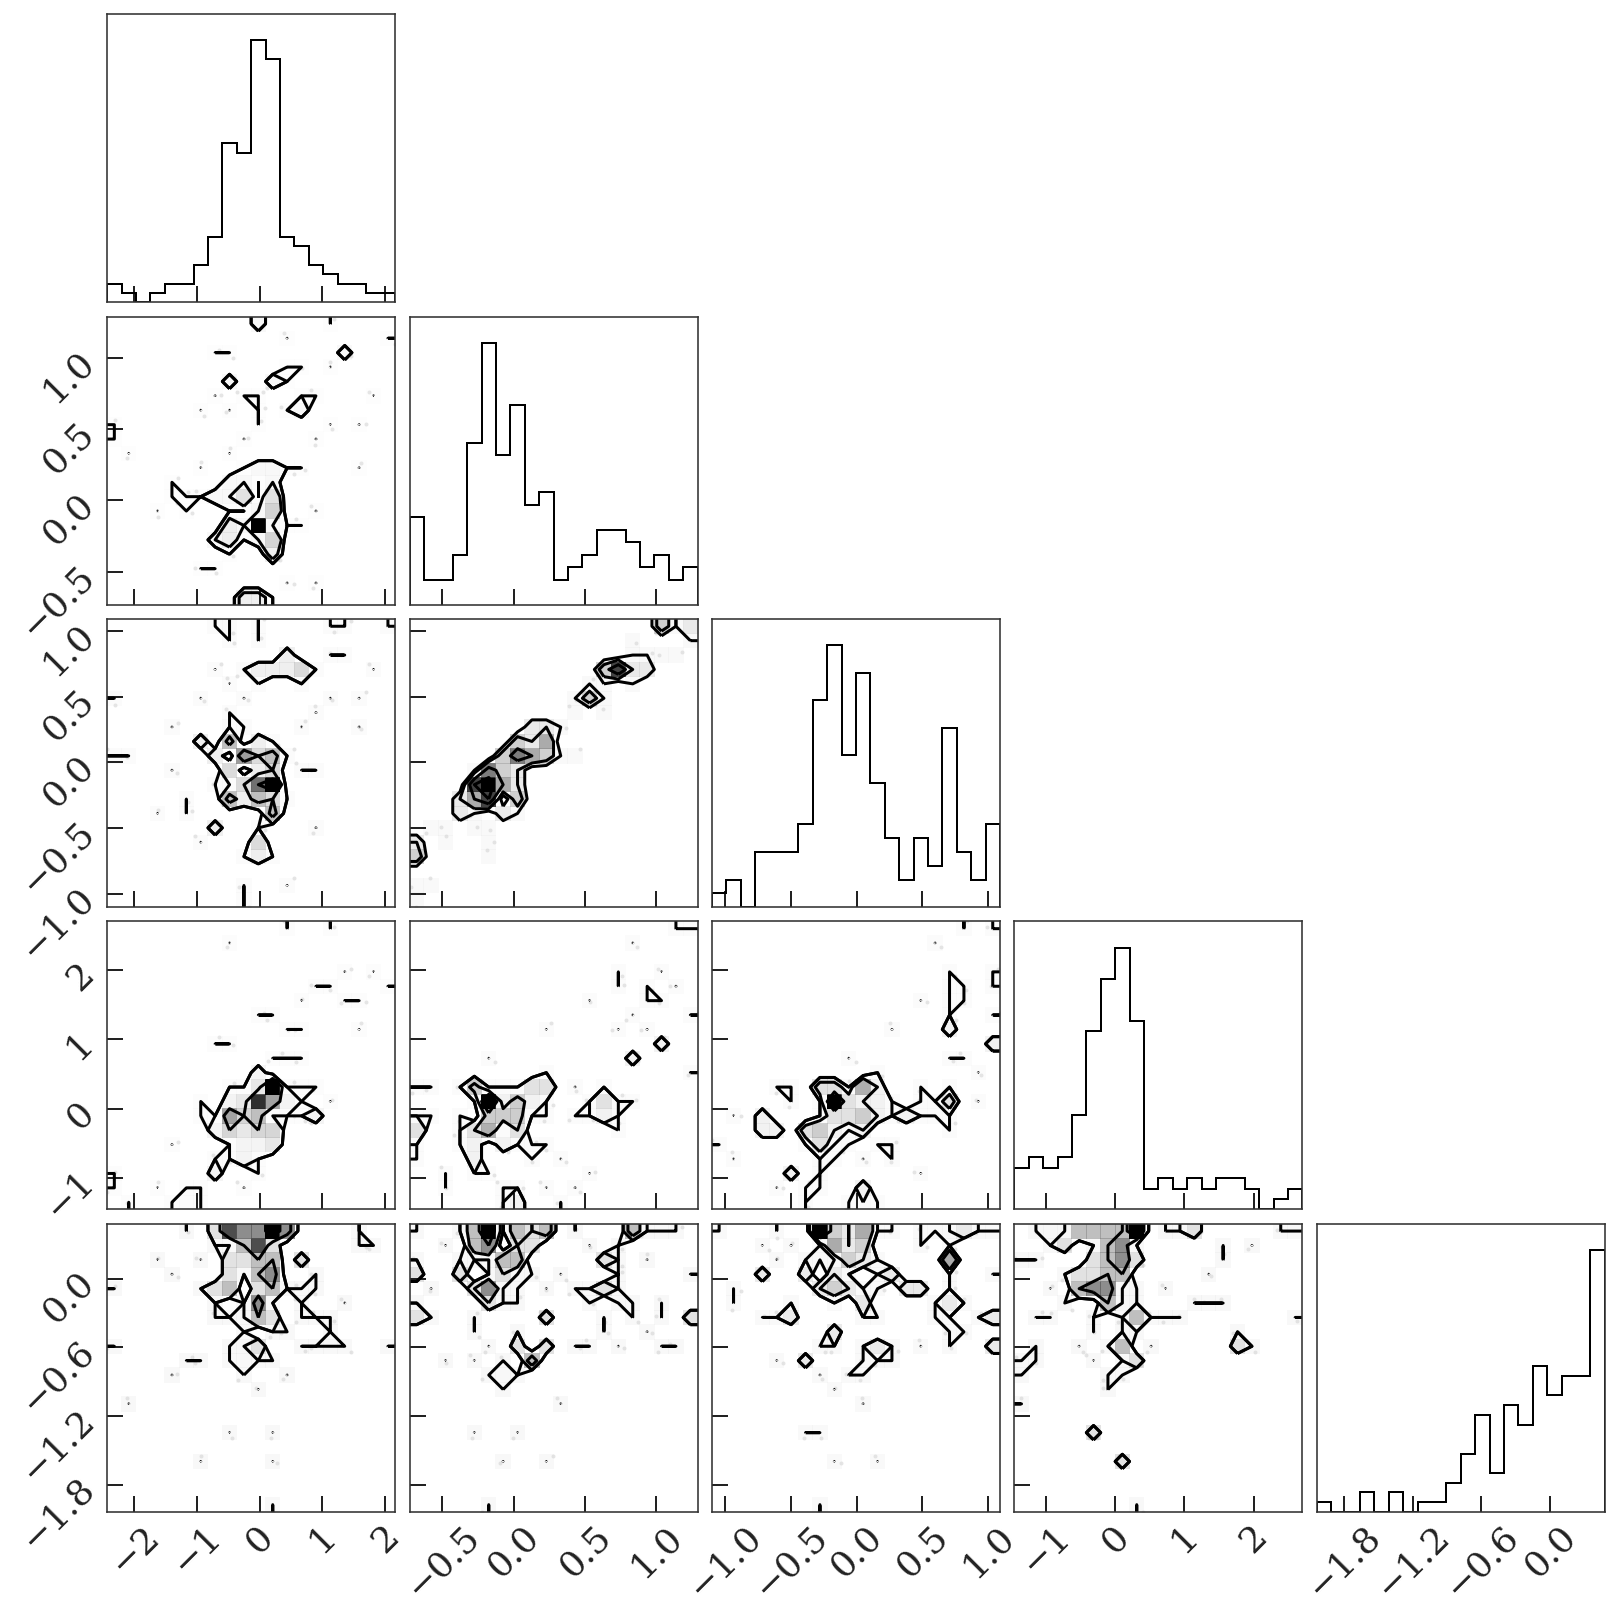

In [577]:
_ = corner.corner(lbl.y)

# Make training and validation samples

cut into fourths

In [578]:
rng = np.random.default_rng(seed=42)
# rando = rng.integers(8, size=len(f_all))
rando = rng.integers(4, size=len(f_all))

In [579]:
# _ = corner.corner(X_train)

In [580]:
# _ = corner.corner(X_valid)

# Run LLVM model


In [581]:
n_labels = len(lbl.labels)
n_latents = n_labels + 3
if 'schmag' in lbl.labels:
    schmag_i = list(lbl.labels.keys()).index('schmag')
else:
    schmag_i = None

In [582]:
res_adams = []
llvms = []
for i in np.unique(rando):
    print("-" * 32)
    print(f"k={i}")
    
    train = rando != i
    valid = (
        ~train #&
    #     (g.LOGG < 2.2) &
    #     ((lbl.vals['schmag'] / lbl.errs['schmag']) > 8)
    )

    f_train = f_all[train]
    f_valid = f_all[valid]

    X_train, X_valid = f_train.X, f_valid.X
    X_train_err, X_valid_err = f_train.X_err, f_valid.X_err
    y_train, y_valid = lbl.y[train], lbl.y[valid]
    y_train_err, y_valid_err = lbl.y_err[train], lbl.y_err[valid]

#     print(X_train.shape, X_valid.shape)
#     print(X_train_err.shape, X_valid_err.shape)
#     print(y_train.shape, y_valid.shape)
#     print(y_train_err.shape, y_valid_err.shape)
    
    kwargs = dict()
    if 'schmag' in lbl.labels:
        kwargs['B_fit_idx'] = [schmag_i]

    llvm = LinearLVM(
        X_train, y_train, 
        X_train_err, y_train_err, 
        n_latents, 
        alpha=1e-1, beta=1e-1,
        verbose=False, 
        rng=np.random.default_rng(conf.seed),
        **kwargs
    )
    
    params0 = {k: llvm.par_state.__dict__[k] for k in llvm.par_state.names}
    # x0 = llvm.pack_p()
    # print("N parameters:", x0.shape)
    
    opt = optax.adam(4e-4)
    solver = jaxopt.OptaxSolver(opt=opt, fun=llvm, maxiter=32768*4)
    res_adam = solver.run(params0)
#     print(res_adam.state.iter_num)
    
    print(
        "Initial, final loss:",
        llvm(params0),
        llvm(res_adam.params)
    )
    llvms.append(llvm)
    res_adams.append(res_adam)

--------------------------------
k=0
Initial, final loss: 103043.28762730723 5777.638646924156
--------------------------------
k=1
Initial, final loss: 99358.12133111678 5675.010644309503
--------------------------------
k=2
Initial, final loss: 91726.93543828889 5109.063705795596
--------------------------------
k=3
Initial, final loss: 104336.79724360204 5357.552725322797


In [583]:
# derp = llvms[0].unpack_p(res_adam.params)
# _ = colored_corner(derp.z, scatter=True, color_by=g.SFD_EBV[train])

In [584]:
all_idx = []
all_predict = []
all_true_y = []
all_true_yerr = []
for j, i in enumerate(np.unique(rando)):
    print(f"K={i}")
    
    train = rando != i
    valid = (
        ~train #&
    #     (g.LOGG < 2.2) &
    #     ((lbl.vals['schmag'] / lbl.errs['schmag']) > 8)
    )

    f_train = f_all[train]
    f_valid = f_all[valid]

    X_train, X_valid = f_train.X, f_valid.X
    X_train_err, X_valid_err = f_train.X_err, f_valid.X_err
    y_train, y_valid = lbl.y[train], lbl.y[valid]
    y_train_err, y_valid_err = lbl.y_err[train], lbl.y_err[valid]
    
    res_state = ParameterState(llvms[j].sizes, **res_adams[j].params)
    
    y_valid_predict = llvm.predict_y(
        X_valid,
        X_valid_err,
        res_state
    )
    all_predict.append(y_valid_predict)
    all_idx.append(np.where(valid)[0])
    all_true_y.append(y_valid)
    all_true_yerr.append(y_valid_err)
    
# valid_predict = lbl._untransform(y_valid_predict)

K=0
K=1
K=2
K=3


In [585]:
_all_predict = lbl._untransform(np.concatenate(all_predict))
_all_true_y = lbl._untransform(np.concatenate(all_true_y))
_all_true_yerr = lbl._untransform(np.concatenate(all_true_yerr), err=True)
_all_idx = np.concatenate(all_idx)

In [586]:
dys = {}
for k in _all_predict:
    dys[k] = _all_predict[k] - _all_true_y[k]

In [587]:
print(n_latents, {k: 1.5 * MAD(x) for k, x in dys.items()})

8 {'TEFF': 137.1436107600805, 'FE_H': 0.2228683033581519, 'MG_H': 0.2696720842662372, 'logg': 0.47045645966007366, 'AK_TARG': 0.03125580952086202}


In [588]:
# fig, axes = plt.subplots(
#     1, y_valid.shape[1], 
#     figsize=(y_valid.shape[1] * 6, 6),
#     constrained_layout=True
# )

# for q, (ax, name) in enumerate(zip(axes, _all_predict.keys())):
#     ax.errorbar(
#         _all_true_y[name],
#         _all_predict[name],
#         xerr=_all_true_yerr[name],
#         ls='none'
#     )
#     ax.set_title(name)
    
#     lim = (_all_true_y[name].min(), _all_true_y[name].max())
#     ax.set_xlim(lim)
#     ax.set_ylim(lim)
    
# for ax in axes:
#     ax.set_xlabel('APOGEE')
# axes[0].set_ylabel('schlummernd')

/tmp/ipykernel_893559/496993476.py:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.autofmt_xdate(rotation=45)


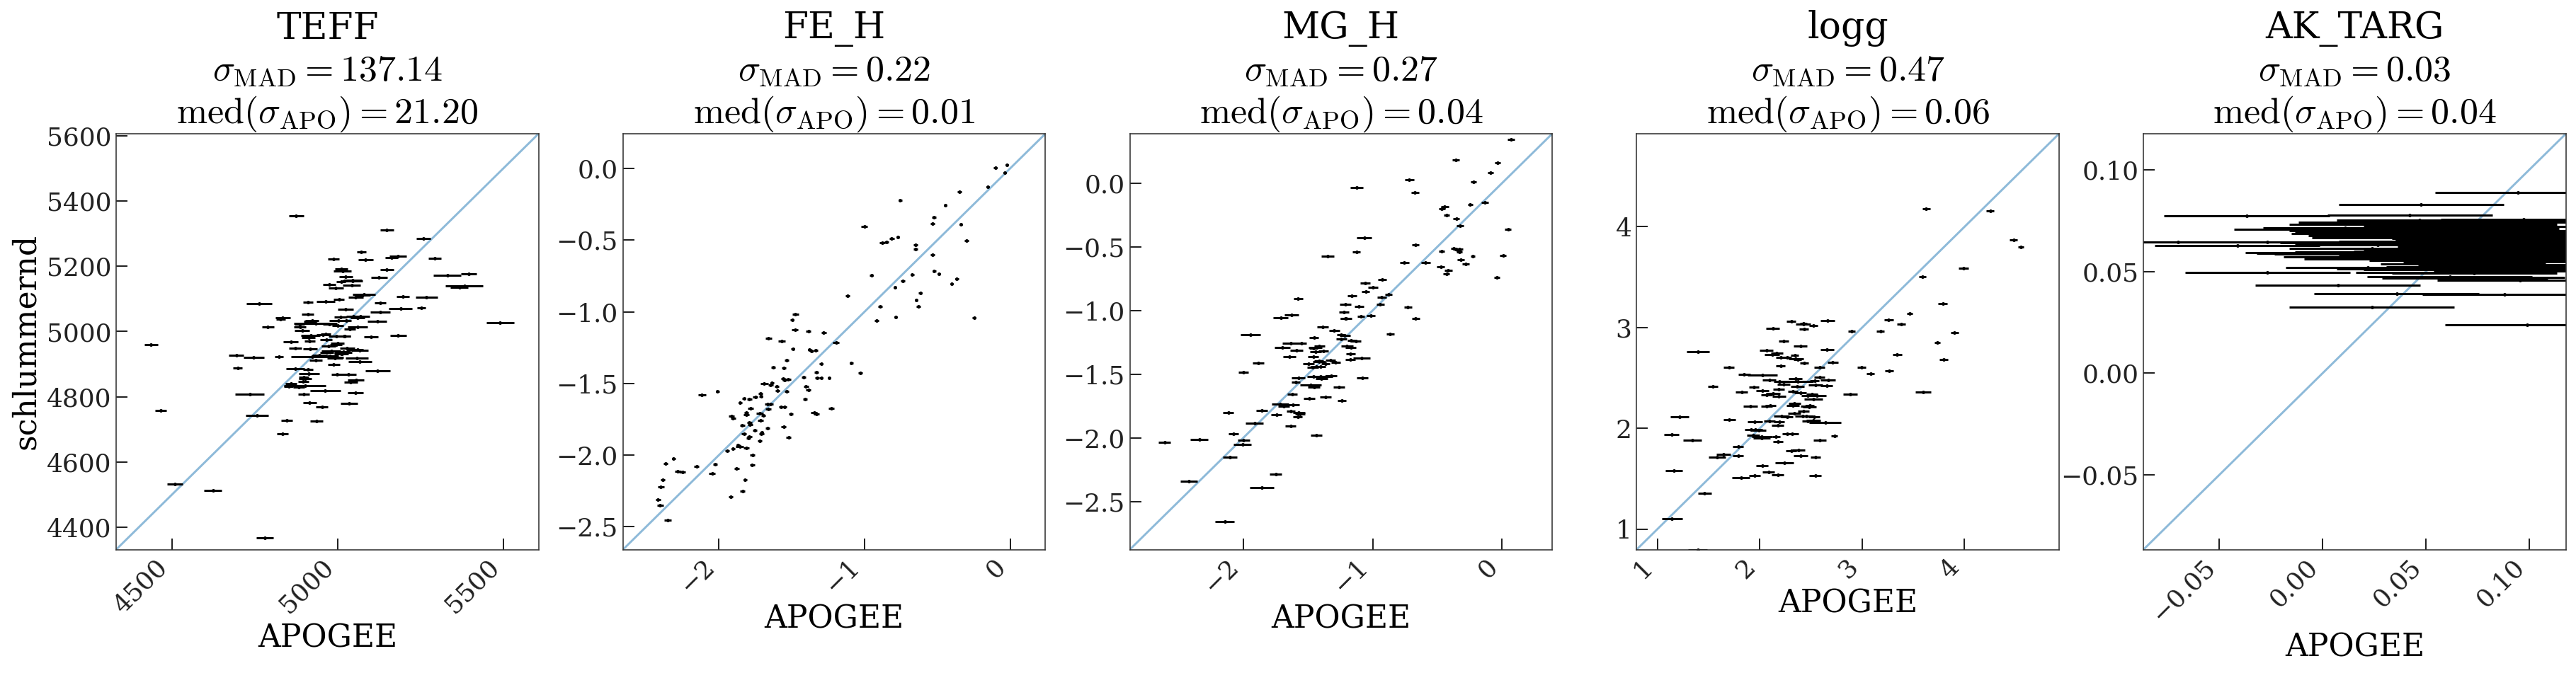

In [589]:
fig, axes = plt.subplots(
    1, y_valid.shape[1], 
    figsize=(y_valid.shape[1] * 6.2, 6.),
    constrained_layout=True
)

# bp_mask = (
#     (g[_all_idx].phot_bp_mean_mag < 15*u.mag) &
#     (g[_all_idx].AK_WISE < 0.1)
# )
bp_mask = np.ones(len(_all_idx), dtype=bool)

for ax in axes:
    ax.set_xlabel('APOGEE')
axes[0].set_ylabel('schlummernd')

fig.autofmt_xdate(rotation=45)

for q, (ax, name) in enumerate(zip(axes, _all_predict.keys())):
    lim = [_all_true_y[name].min(), _all_true_y[name].max()]
    lim[0] = lim[0] - 0.1 * (lim[1]-lim[0])
    lim[1] = lim[1] + 0.1 * (lim[1]-lim[0])
    
    ax.errorbar(
        _all_true_y[name][bp_mask],
        _all_predict[name][bp_mask],
        xerr=_all_true_yerr[name][bp_mask],
        ls='none'
    )
    
    ax.plot([lim[0], lim[1]], [lim[0], lim[1]], 
            marker='', ls='-', color='tab:blue', zorder=-10, alpha=0.5)
    
    dy = _all_predict[name] - _all_true_y[name]
    mad_std = 1.5 * MAD(dy)
    med_apo = np.median(_all_true_yerr[name])
    ax.set_title(
        f"{name}\n"
        r"$\sigma_{\rm MAD}=" + f"{mad_std:.2f}$\n"
        r"${\rm med}(\sigma_{\rm APO})=" + f"{med_apo:.2f}$"
    )
    
    ax.set_xlim(lim)
    ax.set_ylim(lim)

In [590]:
for name in _all_predict.keys():
    # dy = valid_predict[name] - _valid[name]
    dy = _all_predict[name] - _all_true_y[name]
    mad_std = 1.5 * MAD(dy)
    std_deconv = np.sqrt(np.nanvar(dy) - _all_true_yerr[name]**2)
    mad_std_deconv = np.sqrt(mad_std**2 - _all_true_yerr[name]**2)
    print(
        f"{name}:\n"
        f"  sigma={np.std(dy):.3f}\n"
        f"  median deconv. sigma={np.nanmedian(std_deconv):.3f}\n"
        f"  sigma_MAD={mad_std:.3f}\n"
        f"  median deconv. sigma_MAD={np.nanmedian(mad_std_deconv):.3f}\n"
        f"  APOGEE median err={np.median(_all_true_yerr[name]):.3f}\n"
    )

TEFF:
  sigma=160.295
  median deconv. sigma=158.887
  sigma_MAD=137.144
  median deconv. sigma_MAD=135.495
  APOGEE median err=21.201

FE_H:
  sigma=0.245
  median deconv. sigma=0.244
  sigma_MAD=0.223
  median deconv. sigma_MAD=0.222
  APOGEE median err=0.015

MG_H:
  sigma=0.310
  median deconv. sigma=0.307
  sigma_MAD=0.270
  median deconv. sigma_MAD=0.267
  APOGEE median err=0.038

logg:
  sigma=0.518
  median deconv. sigma=0.515
  sigma_MAD=0.470
  median deconv. sigma_MAD=0.467
  APOGEE median err=0.059

AK_TARG:
  sigma=0.035
  median deconv. sigma=nan
  sigma_MAD=0.031
  median deconv. sigma_MAD=nan
  APOGEE median err=0.040



In [591]:
# valid_plx = _all_predict['schmag'] / schmag_factor
# dy = (g.parallax.value - valid_plx) # / g.parallax.value
# print(1.5 * MAD(dy))

# plt.errorbar(
#     g.parallax.value, 
#     dy,
#     # yerr=(g.parallax_error / g.parallax).value, 
#     yerr=g.parallax_error.value, 
#     ms=4, alpha=0.5, ls='none'
# )

---

# Predict variation of XP coefficients with alpha

In [553]:
N_grid = 32

y_median = np.median(y_valid, axis=0)
y_std = np.std(y_valid, axis=0)
scale = np.median(f_valid.bp_scale)
mg_idx = 2

y_grid = np.zeros((N_grid, len(y_median)))
for i in range(len(y_median)):
    y_grid[:, i] = y_median[i]
y_grid[:, mg_idx] = np.linspace(-3 * y_std[mg_idx], 3 * y_std[mg_idx], N_grid) + y_median[mg_idx]

y_grid_unt = lbl._untransform(y_grid)
y_grid_var = list(y_grid_unt.keys())[mg_idx]
y_grid_unt = y_grid_unt[y_grid_var]

X_predict_grid = llvms[-1].predict_X(
    y_grid,
    np.full_like(y_grid, 1e-3),
    res_state
)

N = X_predict_grid.shape[0]
bp_predict_grid = X_predict_grid[:, :f_all.bp.shape[1]] * scale
bp_predict_grid = np.hstack((bp_predict_grid, np.zeros((N, 55 - f_all.bp.shape[1]))))
rp_predict_grid = X_predict_grid[:, f_all.bp.shape[1]:f_all.bp.shape[1] + f_all.rp.shape[1]] * scale
rp_predict_grid = np.hstack((np.full((N, 1), scale), rp_predict_grid, np.zeros((N, 55 - f_all.rp.shape[1] - 1))))

In [554]:
# import gaiaxpy
# gaiaxpy.pwl_to_wl, gaiaxpy.wl_to_pwl

In [555]:
from gaiaxpy.spectrum import (
    _get_covariance_matrix,
    XpContinuousSpectrum,
    XpSampledSpectrum,
)
from gaiaxpy.converter.converter import get_design_matrices, load_config, config_file
config_df = load_config(config_file)

def make_spectrum(data, pseudo_wvln=np.linspace(0, 60, 600), truncation=False):
    sampling = pseudo_wvln
    
    spectra = {}
    for band in ["bp", "rp"]:
        design_matrices = get_design_matrices(data[f"{band}_basis_function_id"][None], sampling, config_df)
        
        # TODO: deal with this
        # C = _get_covariance_matrix(data, band)
        # print(C)
        C = np.eye(55) * 1e-6  # HACK

        continuous_spectrum = XpContinuousSpectrum(
            data["source_id"],
            band,
            data[f"{band}_coefficients"],
            C,
            data[f"{band}_standard_deviation"],
        )

        recommended_truncation = data[f"{band}_n_relevant_bases"] if truncation else -1
        spectrum = XpSampledSpectrum.from_continuous(
            continuous_spectrum,
            design_matrices.get(int(data[f"{band}_basis_function_id"])),
            truncation=recommended_truncation,
        )
        spectra[band] = spectrum
    return spectra

In [556]:
# with h5py.File(
#     "/mnt/ceph/users/gaia/dr3/hdf5/XpContinuousMeanSpectrum/XpContinuousMeanSpectrum_023059-023264.hdf5"
# ) as f:
#     row = {k: np.array(f[k][10]) for k in f.keys()}
# make_spectrum(row, truncation=False)

In [557]:
spectra = []
for i in trange(bp_predict_grid.shape[0]):
    data = {
        "source_id": 0,
        "bp_basis_function_id": np.array(56),
        "rp_basis_function_id": np.array(57),
        "bp_standard_deviation": 1.0,
        "rp_standard_deviation": 1.0,
        "bp_coefficients": bp_predict_grid[i],
        "rp_coefficients": rp_predict_grid[i]
    }
    spec = make_spectrum(data, truncation=False)
    spectra.append(spec)

100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


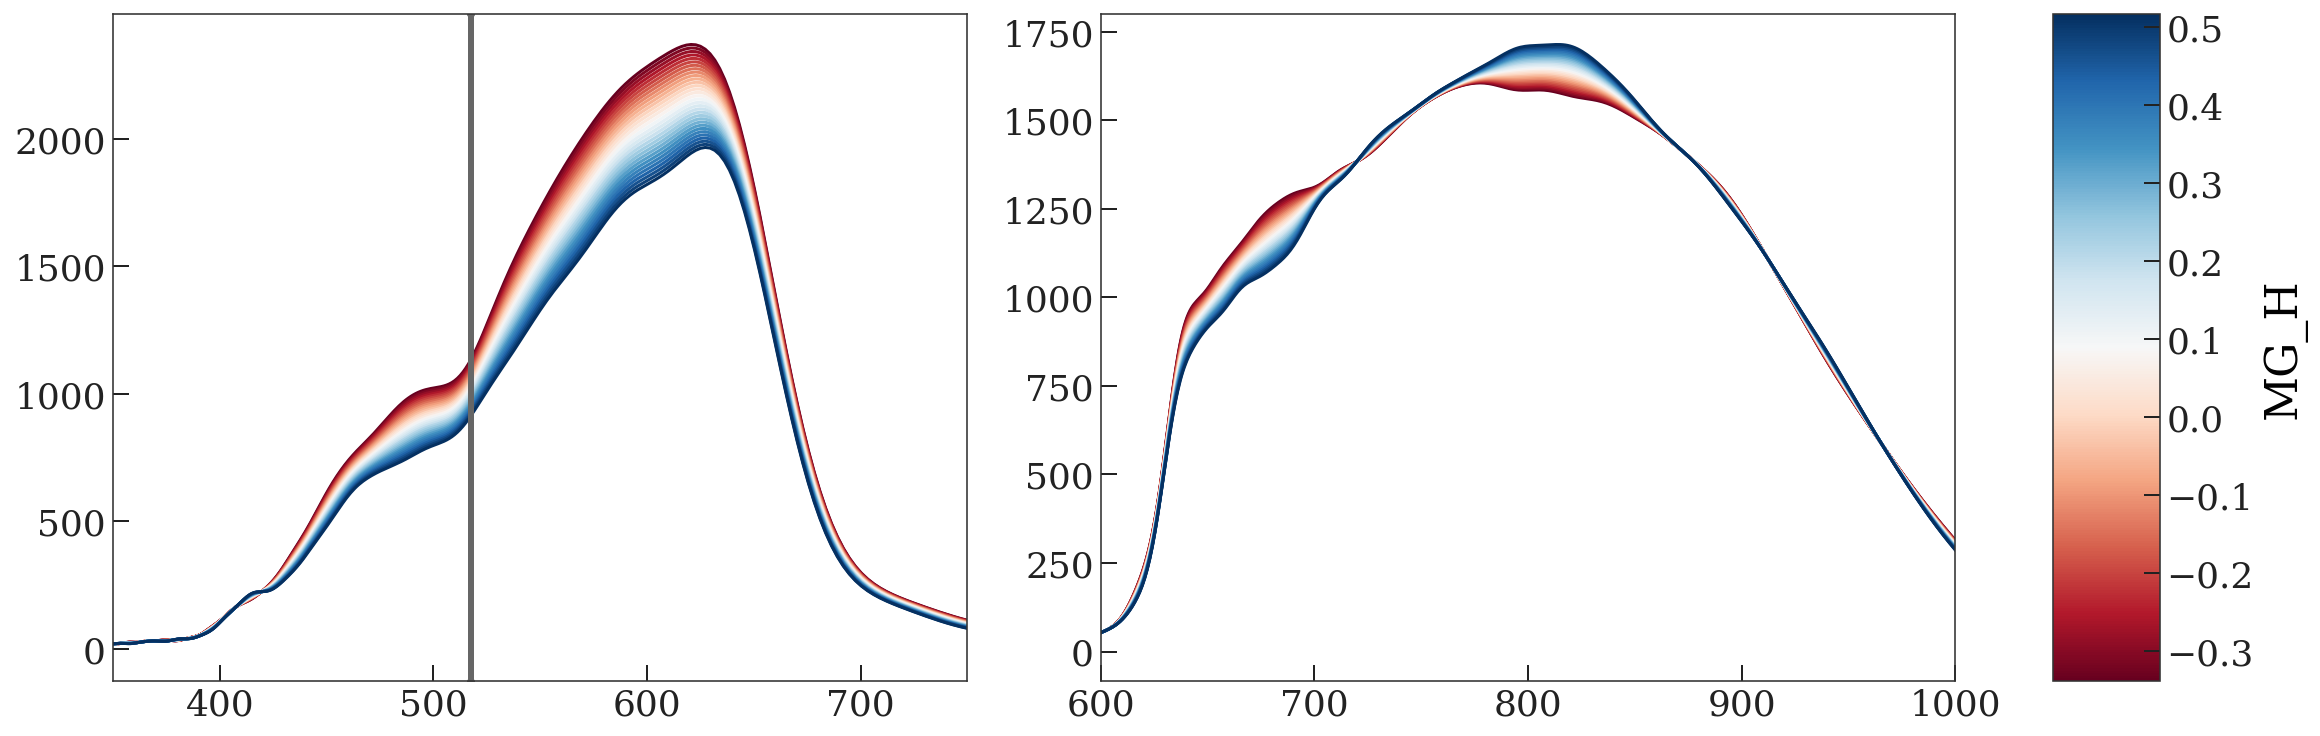

In [558]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

norm = mpl.colors.Normalize(vmin=y_grid_unt.min(), vmax=y_grid_unt.max())
cmap = plt.get_cmap('RdBu')
for band, ax in zip(['bp', 'rp'], axes):
    wvln = gaiaxpy.pwl_to_wl(band, np.linspace(0, 60, 600))

    mid_spec = spectra[len(spectra)//2][band].flux
    for i, spec in enumerate(spectra):
        ax.plot(wvln, spec[band].flux, marker='', color=cmap(norm(y_grid_unt[i])))
    
    for l in [5183, 5172, 5167]:  # Mg
        ax.axvline(l / 10.)
        
axes[0].set_xlim(350, 750)
axes[1].set_xlim(600, 1000)

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes);
cb.set_label(y_grid_var)

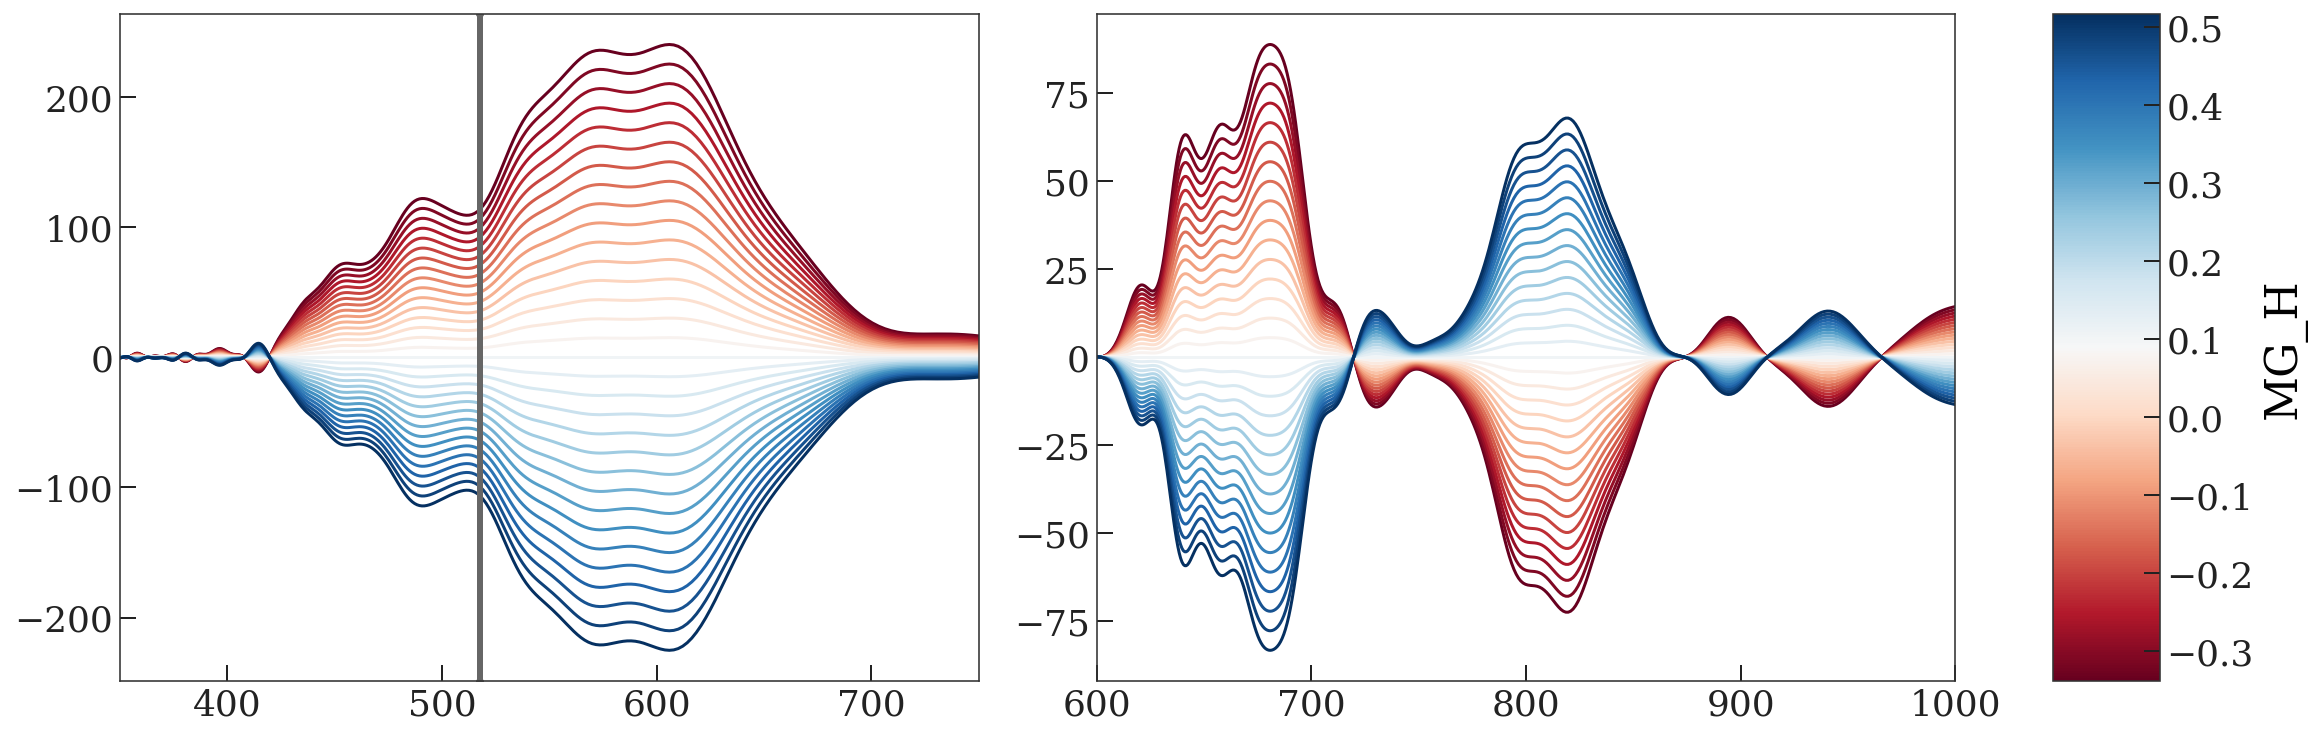

In [559]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

for band, ax in zip(['bp', 'rp'], axes):
    wvln = gaiaxpy.pwl_to_wl(band, np.linspace(0, 60, 600))

    mid_spec = spectra[len(spectra)//2][band].flux
    for i, spec in enumerate(spectra):
        ax.plot(wvln, (spec[band].flux - mid_spec), marker='', color=cmap(norm(y_grid_unt[i])))
    
    for l in [5183, 5172, 5167]:  # Mg
        ax.axvline(l / 10.)
        
axes[0].set_xlim(350, 750)
axes[1].set_xlim(600, 1000)

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes);
cb.set_label(y_grid_var)

APW:
- Vary latents themselves, not labels, and visualize XP spectra
- Switch to using APOGEE FPARAMS and covariance matrix instead of calibrated labels
- Profile vs. slicing
- Covariance matrix of BP/RP coefficients

To discuss:
- Tesselating the CMD
- Line lists for Mg w/ most important lines, molecular bands, etc.